<a href="https://colab.research.google.com/github/Guo-Weiqiang/Master-Project/blob/main/SEED.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
from tqdm import tqdm
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, TensorDataset, DataLoader
from torchsummary import summary

import matplotlib.pyplot as plt

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [12]:

class EEGNet_ReLU(torch.nn.Module):
    def __init__(self, n_output):
        super(EEGNet_ReLU, self).__init__()
        # Adjusted kernel sizes and added more pooling
        self.firstConv = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=(1, 51), stride=(1, 1), padding=(0, 25), bias=False),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=(1, 4))
        )
        # Since we have only one channel, the depthwise convolution is just a regular convolution here
        # Adjust the number of output channels if necessary
        self.depthwiseConv = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=(62, 1), padding=0, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=(1, 8)),
            nn.Flatten()
        )
        # The separable convolution may not be needed, depending on the dimensionality after depthwiseConv
        self.classify = nn.Sequential(
            # The input features to the classifier need to be calculated based on the previous layer's output
            # nn.Linear(36992, 256, bias=True),
            # nn.ReLU(),
            nn.Linear(36992, n_output, bias=True)
        )

    def forward(self, x):
        out = self.firstConv(x)
        features = self.depthwiseConv(out)
        # print(features.shape)
        # out will have reduced dimensionality, you need to calculate 'in_features' based on this.
        out = self.classify(features)
        return out, features


In [13]:
def read_data():
    """
    two subjects: S4b, X11b
    The experiment consists of 3 sessions for each subject. Each session consists of 4 to 9 runs
    """
    train_data = np.load('drive/MyDrive/EEGNet/processed_seed_dataset/subject1.npy')
    test_data = np.load('drive/MyDrive/EEGNet/processed_seed_dataset/subject2.npy')

    train_label = [2, 1, 0, 0, 1, 2, 0, 1, 2, 2, 1, 0, 1, 2, 0] * 3
    test_label = [2, 1, 0, 0, 1, 2, 0, 1, 2, 2, 1, 0, 1, 2, 0] * 3


    mask = np.where(np.isnan(train_data))
    train_data[mask] = np.nanmean(train_data)

    mask = np.where(np.isnan(test_data))
    test_data[mask] = np.nanmean(test_data)

    train_data = torch.from_numpy(train_data).float()
    test_data = torch.from_numpy(test_data).float()
    train_label = torch.tensor(train_label, dtype=torch.long)
    test_label = torch.tensor(test_label, dtype=torch.long)
    val_data = test_data
    val_label = test_label

    print(train_data.shape, train_label.shape, val_data.shape, val_label.shape, test_data.shape, test_label.shape)

    return train_data, train_label, val_data, val_label, test_data, test_label

In [ ]:
source_data, source_label, val_data, val_label, target_data, target_label = read_data()

100%|██████████| 20/20 [00:52<00:00,  2.60s/it]


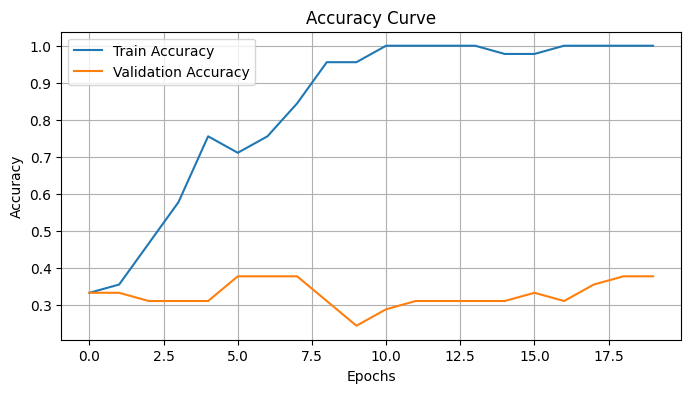

In [18]:
def test(dataloader, model):
    model.eval()
    size = len(dataloader.dataset)
    correct = 0

    with torch.no_grad():

        for x, y in dataloader:
            x, y = x.to(DEVICE), y.to(DEVICE)
            y_pred, features = model(x)
            correct += (torch.max(y_pred, 1)[1] == y).sum().item()

    test_accuracy = correct / size
    return test_accuracy, features


def train(train_data, train_label, val_data, val_label, test_data, test_label, batch_size=15, epochs=500, lr=1e-3):
    train_dataset = TensorDataset(train_data, train_label)
    val_dataset = TensorDataset(val_data, val_label)
    # test_dataset = TensorDataset(test_data, test_label)

    train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=True)
    # target_loader = DataLoader(dataset=target_dataset, batch_size=batch_size, shuffle=False)

    model = EEGNet_ReLU(n_output=3).to(DEVICE)
    # print(model)
    loss_fn = nn.CrossEntropyLoss()

    optimizer = optim.Adam(model.parameters(), lr=lr)
    # optimizer = optim.RMSprop(model.parameters(),lr = lr, momentum = 0.2)
    # optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.5, weight_decay=5e-4)

    # model.cuda(0)
    # summary(model.cuda(),(1, 62, 37001))

    loss_history = []
    train_accuracy_history = []
    val_accuracy_history = []
    test_accuracy_history = []

    for epoch in tqdm(range(1, epochs + 1)):
        model.train()

        running_loss = 0.0
        correct = 0
        total = 0

        for batch, (x, y) in enumerate(train_loader):
            optimizer.zero_grad()

            x, y = x.to(DEVICE), y.to(DEVICE)
            y_pred, source_features = model(x)

            loss = loss_fn(y_pred, y)
            # loss_history.append(loss.item())

            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            correct += (torch.max(y_pred,1)[1] == y).sum().item()
            total += y.size(0)

        train_accuracy = correct / total
        train_accuracy_history.append(train_accuracy)
        val_accuracy, _ = test(val_loader, model)
        # test_accuracy, target_features = test(target_data, target_label, model, device)
        val_accuracy_history.append(val_accuracy)

        # print("epochs:",epoch,"loss:",running_loss,"D_s Accuracy:",train_accuracy, "D_t accuracy", val_accuracy)


    plt.figure(figsize=(8, 4))
    # plt.plot(loss_history, label="Loss")
    plt.plot(train_accuracy_history, label='Train Accuracy')
    plt.plot(val_accuracy_history, label='Validation Accuracy')
    # plt.plot(test_accuracy_history, label='Test Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Accuracy Curve')
    plt.grid(True)
    plt.show()



# source_data, source_label, val_data, val_label, target_data, target_label = read_data()
train(source_data, source_label, val_data, val_label, target_data, target_label, batch_size=15, epochs=20, lr=1e-2)